# Arrival delay time prediction

In [1]:
%matplotlib inline
# import required modules for prediction tasks
import numpy as np
import pandas as pd
import math
import random
import requests
import zipfile
import StringIO
import re
import json
import os
import requests, zipfile, StringIO
import matplotlib
import matplotlib.pyplot as plt

In this notebook, we want to develop a model to predict arrival delay time for flights between two cities. As our primary example we investigate flights from New York(all airports) to Chicago(all airports)

### get the data

In [2]:
# given a list of column labels remove all columns that are in the df
def filterDF(df, cols):
    colsToKeep = list(set(df.columns) & set(cols))
    
    return df[colsToKeep]

In [3]:
# given a dataframe this function groups all manufacturers into one category whose market share is low (default: 1%)
# also groups together some companies
def compressManufacturers(df, percentage=1.):
    df['AIRCRAFT_MFR'] = df['AIRCRAFT_MFR'].map(lambda x: x.strip())
    mfr_stats = df['AIRCRAFT_MFR'].value_counts()
    
    market_share = mfr_stats.values * 100. / np.sum(mfr_stats.values)
    idxs = np.where(market_share < percentage)
    names = np.array([el for el in list(mfr_stats.keys())])

    # get labels for small manufacturers
    smallMFR = names[idxs]

    # perform merging for the big companies
    # Douglas airplanes
    df.loc[df['AIRCRAFT_MFR'] == 'MCDONNELL DOUGLAS AIRCRAFT CO', 'AIRCRAFT_MFR'] = 'MCDONNELL DOUGLAS'
    df.loc[df['AIRCRAFT_MFR'] == 'MCDONNELL DOUGLAS CORPORATION', 'AIRCRAFT_MFR'] = 'MCDONNELL DOUGLAS'
    df.loc[df['AIRCRAFT_MFR'] == 'MCDONNELL DOUGLAS CORPORATION', 'AIRCRAFT_MFR'] = 'DOUGLAS'

    # Embraer
    df.loc[df['AIRCRAFT_MFR'] == 'EMBRAER S A', 'AIRCRAFT_MFR'] = 'EMBRAER'

    # Airbus
    df.loc[df['AIRCRAFT_MFR'] == 'AIRBUS INDUSTRIE', 'AIRCRAFT_MFR'] = 'AIRBUS'

    # the small manufacturers
    for name in smallMFR:
        df.loc[df['AIRCRAFT_MFR'] == name, 'AIRCRAFT_MFR'] = 'SMALL'
        
    return df

To get external aircraft data load additional data file

In [4]:
z = zipfile.ZipFile('externalData/AircraftInformation.zip')
df_master  = pd.DataFrame.from_csv(z.open('MASTER.txt'))
df_aircrafts  = pd.DataFrame.from_csv(z.open('ACFTREF.txt'))
master = df_master[['MFR MDL CODE', 'YEAR MFR']].reset_index()
aircrafts = df_aircrafts['MFR'].reset_index()
master.columns = ['TAIL_NUM', 'CODE', 'YEAR']
aircrafts.columns = ['CODE', 'MFR']
joinedAircraftInfo = pd.merge(master, aircrafts, how='left', on='CODE')

In [5]:
joinedAircraftInfo.TAIL_NUM = joinedAircraftInfo.TAIL_NUM.apply(lambda x: x.strip())

In [6]:
# possible fields
# [u'YEAR', u'QUARTER', u'MONTH', u'DAY_OF_MONTH', u'DAY_OF_WEEK',
#        u'FL_DATE', u'UNIQUE_CARRIER', u'AIRLINE_ID', u'CARRIER', u'TAIL_NUM',
#        u'FL_NUM', u'ORIGIN', u'ORIGIN_CITY_NAME', u'ORIGIN_STATE_ABR',
#        u'ORIGIN_STATE_FIPS', u'ORIGIN_STATE_NM', u'ORIGIN_WAC', u'DEST',
#        u'DEST_CITY_NAME', u'DEST_STATE_ABR', u'DEST_STATE_FIPS',
#        u'DEST_STATE_NM', u'DEST_WAC', u'CRS_DEP_TIME', u'DEP_TIME',
#        u'DEP_DELAY', u'DEP_DELAY_NEW', u'DEP_DEL15', u'DEP_DELAY_GROUP',
#        u'DEP_TIME_BLK', u'TAXI_OUT', u'WHEELS_OFF', u'WHEELS_ON', u'TAXI_IN',
#        u'CRS_ARR_TIME', u'ARR_TIME', u'ARR_DELAY', u'ARR_DELAY_NEW',
#        u'ARR_DEL15', u'ARR_DELAY_GROUP', u'ARR_TIME_BLK', u'CANCELLED',
#        u'CANCELLATION_CODE', u'DIVERTED', u'CRS_ELAPSED_TIME',
#        u'ACTUAL_ELAPSED_TIME', u'AIR_TIME', u'FLIGHTS', u'DISTANCE',
#        u'DISTANCE_GROUP', u'CARRIER_DELAY', u'WEATHER_DELAY', u'NAS_DELAY',
#        u'SECURITY_DELAY', u'LATE_AIRCRAFT_DELAY', u'FIRST_DEP_TIME',
#        u'TOTAL_ADD_GTIME', u'LONGEST_ADD_GTIME', u'DIV_AIRPORT_LANDINGS',
#        u'DIV_REACHED_DEST', u'DIV_ACTUAL_ELAPSED_TIME', u'DIV_ARR_DELAY',
#        u'DIV_DISTANCE', u'DIV1_AIRPORT', u'DIV1_WHEELS_ON',
#        u'DIV1_TOTAL_GTIME', u'DIV1_LONGEST_GTIME', u'DIV1_WHEELS_OFF',
#        u'DIV1_TAIL_NUM', u'DIV2_AIRPORT', u'DIV2_WHEELS_ON',
#        u'DIV2_TOTAL_GTIME', u'DIV2_LONGEST_GTIME', u'DIV2_WHEELS_OFF',
#        u'DIV2_TAIL_NUM', u'DIV3_AIRPORT', u'DIV3_WHEELS_ON',
#        u'DIV3_TOTAL_GTIME', u'DIV3_LONGEST_GTIME', u'DIV3_WHEELS_OFF',
#        u'DIV3_TAIL_NUM', u'DIV4_AIRPORT', u'DIV4_WHEELS_ON',
#        u'DIV4_TOTAL_GTIME', u'DIV4_LONGEST_GTIME', u'DIV4_WHEELS_OFF',
#        u'DIV4_TAIL_NUM', u'DIV5_AIRPORT', u'DIV5_WHEELS_ON',
#        u'DIV5_TOTAL_GTIME', u'DIV5_LONGEST_GTIME', u'DIV5_WHEELS_OFF',
#        u'DIV5_TAIL_NUM', u'Unnamed: 93', u'AIRCRAFT_YEAR', u'AIRCRAFT_AGE',
#        u'AIRCRAFT_MFR']

# define here which columns to include in the data extraction process
columnsToUse = [u'YEAR', u'QUARTER', u'MONTH', u'DAY_OF_MONTH', u'DAY_OF_WEEK',
       u'FL_DATE', u'UNIQUE_CARRIER', u'AIRLINE_ID',u'TAIL_NUM',
       u'FL_NUM', u'ORIGIN', u'ORIGIN_CITY_NAME',
       u'ORIGIN_STATE_NM', u'ORIGIN_WAC', u'DEST',
       u'DEST_CITY_NAME',u'ARR_DELAY', u'ARR_DELAY_NEW',
       u'ARR_DEL15', u'CANCELLED', u'DIVERTED', u'DISTANCE',u'AIRCRAFT_YEAR', u'AIRCRAFT_AGE',
       u'AIRCRAFT_MFR', u'ARR_TIME', u'DEP_TIME']

In [7]:
# given the raw BTS data, this function filters it and returns 
# a filtered version along with how much percent has been removed
def processData(rawData):
    # filter for city first
    filteredData = rawData[(rawData.ORIGIN_CITY_NAME == city_from) & (rawData.DEST_CITY_NAME == city_to)]

    # this is how much percent have been cleaned away!
    cleaned_away = filteredData.count()[0]

    # remove columns that are not needed for the model
    filteredData = filterDF(filteredData, columnsToUse)
    filteredData.reset_index(inplace=True)

    # perform as next step join to amend information by aircraftdata
    delayFinal = filteredData[['TAIL_NUM','UNIQUE_CARRIER']]
    delayFinal.TAIL_NUM = delayFinal.TAIL_NUM.str.strip('N')
    delaymfr = pd.merge(delayFinal, joinedAircraftInfo, how='left', on=['TAIL_NUM'])
    filteredData.TAIL_NUM = delaymfr.TAIL_NUM
    filteredData['AIRCRAFT_YEAR'] = delaymfr.YEAR
    filteredData['AIRCRAFT_MFR'] = delaymfr.MFR

    # get rid of NAN values
    filteredData.dropna(axis = 0, inplace = True)

    # get rid of empty year values
    filteredData = filteredData[filteredData['AIRCRAFT_YEAR'] != '    ']

    # compute age of aircraft
    filteredData['AIRCRAFT_AGE'] = filteredData.YEAR.astype(int) - filteredData.AIRCRAFT_YEAR.astype(int)

    # now, compress manufacturers to only a small amount of companies
    filteredData = compressManufacturers(filteredData)

    cleaned_away = 1. - filteredData.count()[0] * 1. / cleaned_away
    return filteredData, cleaned_away

In [9]:
%%time
# specify here which cities should be investigated
city_from = 'New York, NY'
city_to = 'Chicago, IL'

# the dataframe to store everything in
bigdf = None
ca_statistic = []

years = ['2010', '2011', '2012', '2013', '2014']
months = ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12']
for y in years:
    for m in months:
        
        print 'reading {y}{mo}.zip'.format(y=y, mo = m)
        z = zipfile.ZipFile('cache/{y}{mo}.zip'.format(y=y, mo = m))
        rawData = pd.read_csv(z.open(z.namelist()[0]), low_memory=False)

        print 'processing {y}{mo}.zip'.format(y=y, mo = m)
        df, ca = processData(rawData)
        if bigdf is None:
            bigdf = df
        else:
            bigdf = bigdf.append(df, ignore_index=True)
        ca_statistic.append(('{y}{mo}.zip'.format(y=y, mo = m), ca))
        print '==> cleaned away {pc}%'.format(pc=ca)
        print '==> added entries: {ne}'.format(ne=df.count()[0])

reading 201001.zip
processing 201001.zip
==> cleaned away 0.370071684588%
==> added entries: 703
reading 201002.zip
processing 201002.zip
==> cleaned away 0.399608227228%
==> added entries: 613
reading 201003.zip
processing 201003.zip
==> cleaned away 0.340909090909%
==> added entries: 754
reading 201004.zip
processing 201004.zip
==> cleaned away 0.326858108108%
==> added entries: 797
reading 201005.zip
processing 201005.zip
==> cleaned away 0.332497911445%
==> added entries: 799
reading 201006.zip
processing 201006.zip
==> cleaned away 0.344913151365%
==> added entries: 792
reading 201007.zip
processing 201007.zip
==> cleaned away 0.33932951758%
==> added entries: 808
reading 201008.zip
processing 201008.zip
==> cleaned away 0.325119236884%
==> added entries: 849
reading 201009.zip
processing 201009.zip
==> cleaned away 0.306782334385%
==> added entries: 879
reading 201010.zip
processing 201010.zip
==> cleaned away 0.311588641596%
==> added entries: 897
reading 201011.zip
processing 2

In [10]:
bigdf.head()

,index,ORIGIN_CITY_NAME,ARR_DEL15,FL_NUM,CANCELLED,ARR_DELAY,MONTH,DIVERTED,DAY_OF_MONTH,DEST_CITY_NAME,...,FL_DATE,DISTANCE,ORIGIN_STATE_NM,ARR_TIME,UNIQUE_CARRIER,ORIGIN_WAC,TAIL_NUM,AIRCRAFT_YEAR,AIRCRAFT_MFR,AIRCRAFT_AGE
0,24788,"New York, NY",0,301,0,-23,1,0,12,"Chicago, IL",...,2010-01-12,733,New York,737,AA,22,631AA,1990,BOEING,20
1,24789,"New York, NY",0,301,0,-22,1,0,13,"Chicago, IL",...,2010-01-13,733,New York,738,AA,22,621AA,1975,CESSNA,35
2,24792,"New York, NY",0,301,0,-30,1,0,17,"Chicago, IL",...,2010-01-17,733,New York,730,AA,22,614AA,1989,BOEING,21
3,24802,"New York, NY",0,301,0,2,1,0,28,"Chicago, IL",...,2010-01-28,733,New York,802,AA,22,630AA,1990,BOEING,20
4,24808,"New York, NY",0,303,0,-12,1,0,5,"Chicago, IL",...,2010-01-05,733,New York,803,AA,22,433AA,1987,MCDONNELL DOUGLAS,23


In [11]:
# save to csv
bigdf.to_csv('cache/NY_CH_flights.csv')

# read from csv
bigdf = pd.read_csv('cache/NY_CH_flights.csv')

# #entries
bigdf.count()[0]

39852

# A first predictor
We want to know for a span of days, which flight we should take. Therefore let's choose the popular date for Christmas returning flights 21.12.2015. As we want to use historical data, let's get first clear what data we have. Is it possible to compare flights over the years?

In [12]:
query_day = 21
query_month = 12

# how many flights do exist in all years?
# y = years[-1]
flights = []
flightvalues = []
for y in years:
    query = list(bigdf[bigdf['FL_DATE'] == y+'-'+str(query_month)+'-'+str(query_day)].FL_NUM.astype(int).unique())
    flights.append(query)
    flightvalues += query

In [13]:
# build a matrix
data_matrix = np.zeros((len(flightvalues), len(years)))
# build dict
flightdict = dict(zip(flightvalues, np.arange(0, len(flightvalues))))

In [14]:
# fill datamatrix
for i in xrange(len(years)):
    for j in flights[i]:
        data_matrix[flightdict[j], i] = 1.

In [15]:
grid = np.array([[0, 1, 1], [1, 1, 0], [1, 1, 1]])

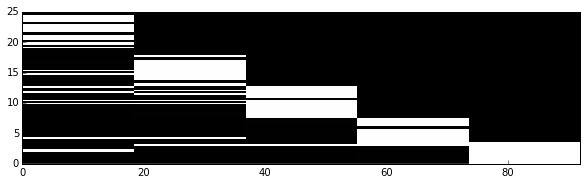

In [16]:
plt.figure(figsize=(10, 6))
plt.imshow(data_matrix, extent=[0,data_matrix.shape[0],0,data_matrix.shape[1] * 5], interpolation='none', cmap='gray')

As the plot shows, comparison is not really possible. It seems as if airlines change their flight numbers on a yearly basis. Thus we need to come up with another idea.

One of the easiest ideas is to average the delay time over each day and refine then.

In [17]:
dffordate = bigdf[bigdf.MONTH == query_month]
dffordate = dffordate[dffordate.DAY_OF_MONTH == query_day]
dffordate.head()

def predict_base_model(X):
    return np.array([dffordate.ARR_DELAY.mean()]*X.shape[0])

To test the quality of this model, we use the last year as test set and the previous as train data. The idea is, that we are always interested in predicting the next year somehow. Thus, if the match for 2014 is good, we expect it to be the same for 2015.

In [18]:
# build test/train set
df_train = dffordate[dffordate.YEAR != int(years[-1])]
df_test = dffordate[dffordate.YEAR == int(years[-1])]

In [22]:
y_train = df_train.ARR_DELAY
X_train = y_train # here dummy
y_test = df_test.ARR_DELAY
X_test = y_test # here dummy

In the base model, the prediction for 2014 is that we are going to be 27.72minutes late

In [23]:
y_pred = predict_base_model(X_test)
y_pred[0]

27.728260869565219

How good did it perform comparing the actual arrival delay?

In [24]:
def rmse(y, y_pred):
    return np.sqrt(((y - y_pred)**2).mean())

In [25]:
rmse(y_test, y_pred)

44.10756003440288

## Building a linear regression model for prediction

One first step is to bin the arrival and departure times.

In [99]:
bigdf.columns

Index([u'Unnamed: 0', u'index', u'ORIGIN_CITY_NAME', u'ARR_DEL15', u'FL_NUM',
       u'CANCELLED', u'ARR_DELAY', u'MONTH', u'DIVERTED', u'DAY_OF_MONTH',
       u'DEST_CITY_NAME', u'ORIGIN', u'DEP_TIME', u'DEST', u'ARR_DELAY_NEW',
       u'DAY_OF_WEEK', u'YEAR', u'AIRLINE_ID', u'QUARTER', u'FL_DATE',
       u'DISTANCE', u'ORIGIN_STATE_NM', u'ARR_TIME', u'UNIQUE_CARRIER',
       u'ORIGIN_WAC', u'TAIL_NUM', u'AIRCRAFT_YEAR', u'AIRCRAFT_MFR',
       u'AIRCRAFT_AGE', u'HOUR_OF_ARR', u'HOUR_OF_DEP'],
      dtype='object')

In [100]:
%%time
bigdf['HOUR_OF_ARR'] = 0
bigdf['HOUR_OF_DEP'] = 0

for index, row in bigdf.iterrows():
    bigdf.set_value(index, 'HOUR_OF_ARR', int(row['ARR_TIME']) / 10)
    bigdf.set_value(index, 'HOUR_OF_DEP', int(row['DEP_TIME']) / 10)

CPU times: user 2.94 s, sys: 63.9 ms, total: 3.01 s
Wall time: 3.1 s


In [101]:
# split data into numerical and categorical features
numericalFeat = bigdf[['DISTANCE', 'AIRCRAFT_AGE']].astype('float') # Numerical features
categoricalFeat = bigdf[['MONTH', 'DAY_OF_MONTH', 'ORIGIN', 
                    'DEST', 'HOUR_OF_ARR', 'HOUR_OF_DEP', 
                    'UNIQUE_CARRIER', 'DAY_OF_WEEK', 'AIRCRAFT_MFR']] # Categorical features

In [102]:
# for the next step, all features need to be encoded as integers --> create lookup Tables!
def transformToID(df, col):
    vals = df[col].unique()
    LookupTable = dict(zip(vals, np.arange(len(vals))))
    for key in LookupTable.keys():
        df[df[col] == key] = LookupTable[key]
    return (LookupTable, df)

In [103]:
%%time 
mfrDict, categoricalFeat = transformToID(categoricalFeat, 'AIRCRAFT_MFR')
originDict, categoricalFeat = transformToID(categoricalFeat, 'ORIGIN')
destDict, categoricalFeat = transformToID(categoricalFeat, 'DEST')
carrierDict, categoricalFeat = transformToID(categoricalFeat, 'UNIQUE_CARRIER')

CPU times: user 26.1 s, sys: 264 ms, total: 26.3 s
Wall time: 27 s


/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [104]:
categoricalFeat.head()

,MONTH,DAY_OF_MONTH,ORIGIN,DEST,HOUR_OF_ARR,HOUR_OF_DEP,UNIQUE_CARRIER,DAY_OF_WEEK,AIRCRAFT_MFR
0,0,0,0,0,0,0,0,0,0
1,1,1,1,1,1,1,1,1,1
2,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0
4,2,2,2,2,2,2,2,2,2


In [105]:
numericalFeat.head()

,DISTANCE,AIRCRAFT_AGE
0,733,20
1,733,35
2,733,21
3,733,20
4,733,23


In [106]:
# Encode categorical variables as binary ones
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder() 
categoricals_encoded = encoder.fit_transform(categoricalFeat)

In [107]:
# convert numerical features to sparse matrix
from scipy import sparse
numericals_sparse = sparse.csr_matrix(numericalFeat)

In [108]:
# get data matrix & response variable
X_all = sparse.hstack((numericals_sparse, categoricals_encoded))
y_all = bigdf['ARR_DELAY'].values

In [109]:
# construct test/train set
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size = 0.2, random_state = 42)

In [111]:
# before starting the regression, numerical features need to be standardized!
from sklearn.preprocessing import StandardScaler

X_train_numericals = X_train[:, 0:3].toarray()
X_test_numericals = X_test[:, 0:3].toarray()

# use sklearn tools...
scaler = StandardScaler() 
scaler.fit(X_train_numericals) # get std/mean from train set
X_train_numericals = sparse.csr_matrix(scaler.transform(X_train_numericals)) 
X_test_numericals = sparse.csr_matrix(scaler.transform(X_test_numericals))

# update sets
X_train[:, 0:3] = X_train_numericals
X_test[:, 0:3] = X_test_numericals

### Ridge regression

In [112]:
# Use ridge regression (i.e. Gaussian prior) and vary the lambda parameter using Grid search
from sklearn.linear_model import SGDRegressor
from sklearn.grid_search import GridSearchCV

SGD_params = {'alpha': 10.0 ** -np.arange(1,8)}
SGD_model = GridSearchCV(SGDRegressor(random_state = 42), \
                         SGD_params, scoring = 'mean_absolute_error', cv = 6) # cross validate 6 times

In [113]:
%%time
# train the model, this might take some time...
SGD_model.fit(X_train, y_train)

CPU times: user 1.3 s, sys: 8.95 ms, total: 1.31 s
Wall time: 1.32 s


GridSearchCV(cv=6, error_score='raise',
       estimator=SGDRegressor(alpha=0.0001, average=False, epsilon=0.1, eta0=0.01,
       fit_intercept=True, l1_ratio=0.15, learning_rate='invscaling',
       loss='squared_loss', n_iter=5, penalty='l2', power_t=0.25,
       random_state=42, shuffle=True, verbose=0, warm_start=False),
       fit_params={}, iid=True, loss_func=None, n_jobs=1,
       param_grid={'alpha': array([  1.00000e-01,   1.00000e-02,   1.00000e-03,   1.00000e-04,
         1.00000e-05,   1.00000e-06,   1.00000e-07])},
       pre_dispatch='2*n_jobs', refit=True, score_func=None,
       scoring='mean_absolute_error', verbose=0)

In [142]:
from sklearn.metrics import mean_squared_error

y_pred = SGD_model.predict(X_test)
rmse(y_test, y_pred)

48.366834575559849

### OLS based linear regression model

In [143]:
import sklearn
from sklearn import linear_model

# use all CPU power!
clf = sklearn.linear_model.LinearRegression()

# fit the model!
clf.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [144]:
y_pred = SGD_model.predict(X_test)
rmse(y_test, y_pred)

48.366834575559849

In [145]:
X_test.toarray()

array([[ 0.04326227,  0.58407066, -0.44106357, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.68271074, -0.87076288, -0.44106357, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.04326227,  0.0706    , -0.44106357, ...,  0.        ,
         0.        ,  0.        ],
       ..., 
       [ 0.04326227,  0.32733533, -0.44106357, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.04326227, -0.27171377, -0.44106357, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.04326227, -0.27171377, -0.44106357, ...,  0.        ,
         0.        ,  0.        ]])

In [146]:
clf.coef_

array([ 1.19928342,  0.9509056 ,  2.06800045, -0.24940167, -0.66548389,
       -0.97159704,  0.20346512,  1.21962386, -0.05589239,  0.60478787,
        0.16326631, -0.06471128, -1.97449098, -0.65260946,  0.04920967,
       -3.74946182,  1.0992649 ,  0.29794088,  0.66053055,  0.11732689,
       -0.24940167, -0.66548389, -0.97159704,  0.20346512,  1.21962386,
       -0.05589239,  0.60478787,  0.16326631, -0.06471128, -1.97449098,
       -0.65260946,  0.04920967, -3.74946182,  1.0992649 ,  0.29794088,
        0.66053055,  0.11732689, -0.24940167, -0.66548389, -0.97159704,
        0.20346512,  1.21962386, -0.05589239,  0.60478787,  0.16326631,
       -0.06471128, -1.97449098, -0.65260946,  0.04920967, -3.74946182,
        1.0992649 ,  0.29794088,  0.66053055,  0.11732689, -0.24940167,
       -0.66548389, -0.97159704,  0.20346512,  1.21962386, -0.05589239,
        0.60478787,  0.16326631, -0.06471128, -1.97449098, -0.65260946,
        0.04920967, -3.74946182,  1.0992649 ,  0.29794088,  0.66